# What Determines A Soccer Player's Salary?
#### *By Peter Feeney*

## Introduction
![MLS](https://stmedia.stimg.co/MLS_FOSTERING_AMID_CORONAVIRUS_SOCCER_58990774.JPG?auto=compress&crop=faces&dpr=1&w=525)

There can be no doubt about it -- soccer is growing incredibly rapidly in the United States. [MLS player salaries go up every year, as does average attendance for MLS games.](https://www.schneiderdowns.com/our-thoughts-on/growth-of-soccer-in-america) And the league is still actively expanding. The number of high school soccer players has grown by 30% since 2004. And we have a world cup winning woman's team!

MLS salaries are pretty high by normal people standard, with a median income of [$179,000](https://www.nytimes.com/2020/02/06/sports/soccer/major-league-soccer-reaches-a-deal-with-its-players.html#:~:text=The%20average%20M.L.S.,players%2C%20earned%20less%20than%20%24100%2C000) but relatively low by professional player standards. Keep in mind that the average NFL player makes a median salary of [$860,000](https://work.chron.com/much-money-nfl-player-make-year-2377.html#:~:text=The%20median%20salary%20for%20all,high%20incomes%20of%20top%20quarterbacks).

In this tutorial, our goal is to analyze the distribution of soccer players' salaries, find what factors determine a soccer player's salary, and see if we can predict a soccer player's salary from their stats. We should be able to use the exploratory data analysis techniques and machine learning algorithms we learned in class to do so.

It is my hope that this tutorial will provide some insights into what skills a soccer player should have to be considered "valuable" by professional teams. It is well-documented that many MLS players are unhappy with their salary -- over a third make less than [$100,000](https://www.nytimes.com/2020/02/06/sports/soccer/major-league-soccer-reaches-a-deal-with-its-players.html#:~:text=The%20average%20M.L.S.,players%2C%20earned%20less%20than%20%24100%2C000) a year. While I can't provide any macroeconomic solutions to these problems, hopefully I can give people some insight into how they should train if they want a pay raise.

## Required Tools
I'll use a standard set of libraries here: NumPy to store arrays, pandas to store data in tabular form, seaborn for simple and visually appealing data visualization, scikit-learn for machine learning, etc.

I am also using the powerlaw library. powerlaw is a python package that makes it simple to analyze heavy-tailed distributions. The relevance of this will become clear later on. You can find out more about powerlaw [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777).

In [464]:
# Necessary tools to complete this tutorial
import numpy as np
import pandas as pd
import re
import matplotlib
import powerlaw
import matplotlib.pyplot as plt
from ast import literal_eval
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor


I created a short helper function that gives somes important information about a pandas dataframe -- the names of its columns and the number of rows it contains -- and then shows that dataframe's first few rows. This is completely optional but it can be helpful when you're working with dataframes that have a fair number of columns.

In [465]:
# Utility function to describe dataframes
def describe(df):
    print("This dataframe has columns: " + str(df.columns))
    print("This data frame has " +  str(len(df)) + " rows")
    return df.head()

## Data Collection
[Kaggle](www.kaggle.com) is an online community of data scientists and machine learning practioners. They have over 50,000 public datasets to work with. Two in particular look like they will be very useful to us. [This dataset](https://www.kaggle.com/crawford/us-major-league-soccer-salaries) gives the salaries of Major League Soccer players from 2007 to 2017. [This dataset](https://www.kaggle.com/josephvm/major-league-soccer-dataset) contains data about every outfield player who's played in the MLS from 1996 to 2020. 

Neither dataset contains enough data on its own to draw any conclusions about the relationship between a player's performance and his salary. But by merging the two together we will have a dataset that will work well for our purposes.

In [466]:
# Utility function that makes it simple to read in salary data in a given year to pandas
def create_df_from_salary_year(path):
    df = pd.read_csv(path)
    # Determine the year that we're working with and put it in the dataframe
    year = re.search('[0-9]+', path)[0]
    df["year"] = int(year)
    return df

We are given salary data from 2007 - 2017 in a different .csv file for each year. The .csv files are identical in structure (same column names). Here we put all of the data together into a single dataframe for ease of analysis.

In [467]:
# Import dataframes

# Read in data about players' performance
player_stats = pd.read_csv("player_stats.csv")

# Read in salary data
seven, eight = create_df_from_salary_year("mls-salaries-2007.csv"), create_df_from_salary_year("mls-salaries-2008.csv")
nine, ten = create_df_from_salary_year("mls-salaries-2009.csv"), create_df_from_salary_year("mls-salaries-2010.csv")
eleven, twelve = create_df_from_salary_year("mls-salaries-2011.csv"), create_df_from_salary_year("mls-salaries-2012.csv")
thirteen, fourteen = create_df_from_salary_year("mls-salaries-2013.csv"), create_df_from_salary_year("mls-salaries-2014.csv")
fifteen, sixteen = create_df_from_salary_year("mls-salaries-2015.csv"), create_df_from_salary_year("mls-salaries-2016.csv")
seventeen = create_df_from_salary_year("mls-salaries-2017.csv")

years = [seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen]

# Cocatenate all of the data from different years together into one unified dataframe
salary_df = pd.concat(years)

describe(salary_df)

This dataframe has columns: Index(['club', 'last_name', 'first_name', 'position', 'base_salary',
       'guaranteed_compensation', 'year'],
      dtype='object')
This data frame has 5553 rows


,club,last_name,first_name,position,base_salary,guaranteed_compensation,year
0,CHI,Armas,Chris,M,225000.0,225000.0,2007
1,CHI,Banner,Michael,M,12900.0,12900.0,2007
2,CHI,Barrett,Chad,F,41212.5,48712.5,2007
3,CHI,Blanco,Cuauhtemoc,F,2492316.0,2666778.0,2007
4,CHI,Brown,C.J.,D,106391.0,106391.0,2007


As one can see, we are given quite a bit of useful data from the salary dataset -- a player's name, his salary, the year in which he played -- but certainly not enough to discover any meaningful insights about the causal factors behind a player's salary.

Let's see what the "player stats" dataset has to offer us:

In [468]:
describe(player_stats)

This dataframe has columns: Index(['Player', 'Club', 'POS', 'GP', 'GS', 'MINS', 'G', 'A', 'SHTS', 'SOG',
       'GWG', 'PKG/A', 'HmG', 'RdG', 'G/90min', 'SC%', 'GWA', 'HmA', 'RdA',
       'A/90min', 'FC', 'FS', 'OFF', 'YC', 'RC', 'SOG%', 'Year', 'Season'],
      dtype='object')
This data frame has 15076 rows


,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,RdA,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season
0,Roy Lassiter,TB,F,30,30,2580,27,4,76,49,...,2,0.14,20,39,70,2,0,64.47,1996,reg
1,Raul Diaz Arce,DC,F,28,28,2351,23,2,100,49,...,2,0.08,32,26,35,6,1,49.00,1996,reg
2,Eduardo Hurtado,LA,F,26,26,2323,21,7,87,56,...,3,0.27,48,26,25,5,0,64.37,1996,reg
3,Preki,KC,M,32,32,2880,18,13,140,61,...,4,0.41,26,44,7,3,0,43.57,1996,reg
4,Brian McBride,CLB,F,28,28,2307,17,3,79,44,...,1,0.12,21,46,10,0,0,55.70,1996,reg


This dataset clearly gives us a lot more features to work with. From this dataset we have information on a player's:
<ol>
<li>Name</li>
<li>Team</li>
<li>Position</li>
<li>Games Played</li>
<li>Games Started</li>
<li>Minutes Played</li>
<li>Goals</li>
<li>Assists</li>
<li>Shots Attempted</li>
<li>Shots on Goal</li>
<li>Game Winning Goal</li>
<li>Penalty Kick Goals / Penalty Kick Attempts (unfortunately this one has some malformed data so I'm just going to drop it)</li>
<li>Home Goals</li>
<li>Road Goals</li>
<li>Goals per 90 Minutes Played</li>
<li>I don't know. It's hard to know what "SC%" is referring to, so we'll drop this column.</li>
<li>Game Winning Assists</li>
<li>Home Assists</li>
<li>Road Assists</li>
<li>Assists per 90 Minutes</li>
<li>Fouls Committed</li>
<li>Fouls Sustained</li>
<li>Offsides Penalties</li>
<li>Yellow Cards</li>
<li>Red Cards</li>
<li>Shots on Goal</li>
<li>Year Played</li>
<li>Are these regular or postseason stats?</li>
</ol>

## Tidying Player Stats

#### Should we drop any columns in player stats?

There's a lot of features to work with! In fact, there's probably too many features to work with. It can be hard to fit ML models to high-dimensional data. It's also harder to make sense of the dataframe on a qualitative level when there's a lot of columns. So it's worth thinking about what columns we can drop now. 

I'd guess that some of the columns in the dataframe don't have a significant impact on salary. I think in particular that the number of fouls a player sustains and the number of yellow cards a player gets in a season aren't connected to his salary, simply because these things don't often have an impact on the way a game goes. It's annoying for a player to get a lot of yellow cards but all in all it's not that important. Offsides penalities and red cards can cause a lot of problems for a team so on an intutive level it makes sense to keep those as features in whatever ML model we end up using.

"What features have a meaningful output on the output variable?" is a question that can be answered with empirical analysis/ We'll come back to this question.

The bigger problem at the moment is that some columns in this dataframe are redundant. We probably don't need to know how many goals or assists a player scored at home and on the road, since already know the total number of goals and assists a player scored. Similarly it doesn't make much sense to include both "goals scored" and "goals scored every 90 minute" as columns here. 

We'll go ahead and drop the following columns:

<ol>
<li>"SC%" (can't figure out what it's supposed to mean)</li>
<li>Home Goals</li>
<li>Road Goals</li>
<li>Home Assists</li>
<li>Road Assists</li>
<li>Penalty Kick Goals / Penalty Kick Attempts</li>
<li>Goals per 90 Minutes</li>
<li>Assists per 90 Minutes</li>
</ol>

We should also change player_stats "Year" column to be named as "year" to correspond with the salary dataframes "year" column. This will make it easier to merge the two dataframes together.


In [469]:
# Drop mentioned columns
player_stats.drop(['SC%', 'HmG', 'RdG', 'HmA','RdA','G/90min','A/90min', "PKG/A"], axis=1, inplace=True)
# Make year lowercase to easily merge datasets together
player_stats.rename(mapper={"Year" : "year"}, axis=1, inplace=True)
describe(player_stats)

This dataframe has columns: Index(['Player', 'Club', 'POS', 'GP', 'GS', 'MINS', 'G', 'A', 'SHTS', 'SOG',
       'GWG', 'GWA', 'FC', 'FS', 'OFF', 'YC', 'RC', 'SOG%', 'year', 'Season'],
      dtype='object')
This data frame has 15076 rows


,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,GWA,FC,FS,OFF,YC,RC,SOG%,year,Season
0,Roy Lassiter,TB,F,30,30,2580,27,4,76,49,4,2,20,39,70,2,0,64.47,1996,reg
1,Raul Diaz Arce,DC,F,28,28,2351,23,2,100,49,4,0,32,26,35,6,1,49.00,1996,reg
2,Eduardo Hurtado,LA,F,26,26,2323,21,7,87,56,6,0,48,26,25,5,0,64.37,1996,reg
3,Preki,KC,M,32,32,2880,18,13,140,61,3,2,26,44,7,3,0,43.57,1996,reg
4,Brian McBride,CLB,F,28,28,2307,17,3,79,44,3,0,21,46,10,0,0,55.70,1996,reg


## Tidying the Salary Dataframe
We should merge the first/last name columns into a single "name" column, since this is the way player_stats is set up and we want to merge the two dataframes together.

A player's guarenteed compensation is a more accurate measure of how much money he makes than his base pay, so we'll go ahead and drop the base pay column.

In [470]:
salary_df["Player"] = salary_df["first_name"] + " " + salary_df["last_name"]
salary_df.drop(["last_name", "first_name", "base_salary"], axis=1, inplace=True)
describe(salary_df)

This dataframe has columns: Index(['club', 'position', 'guaranteed_compensation', 'year', 'Player'], dtype='object')
This data frame has 5553 rows


,club,position,guaranteed_compensation,year,Player
0,CHI,M,225000.0,2007,Chris Armas
1,CHI,M,12900.0,2007,Michael Banner
2,CHI,F,48712.5,2007,Chad Barrett
3,CHI,F,2666778.0,2007,Cuauhtemoc Blanco
4,CHI,D,106391.0,2007,C.J. Brown


Let's go ahead and merge the two dataframes together:

In [471]:
# Join dataframes together. Each unique entry defined by a player's name and the year in which he played.
df = pd.merge(left=player_stats, right=salary_df, on=["Player", "year"])
# Drop the duplicate position and club columns
df.drop(["Club", "position"], axis=1, inplace=True)
describe(df)

This dataframe has columns: Index(['Player', 'POS', 'GP', 'GS', 'MINS', 'G', 'A', 'SHTS', 'SOG', 'GWG',
       'GWA', 'FC', 'FS', 'OFF', 'YC', 'RC', 'SOG%', 'year', 'Season', 'club',
       'guaranteed_compensation'],
      dtype='object')
This data frame has 6532 rows


,Player,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,FC,FS,OFF,YC,RC,SOG%,year,Season,club,guaranteed_compensation
0,Luciano Emilio,F,29,28,2410,20,1,79,47,4,...,35,39,21,2,0,59.49,2007,reg,DC,293125.0
1,Luciano Emilio,F,2,1,77,0,0,2,2,0,...,0,1,0,0,0,100.00,2007,post,DC,293125.0
2,Juan Pablo Angel,F,24,24,2125,19,5,97,53,5,...,31,20,42,2,1,54.64,2007,reg,NY,1593750.0
3,Juan Pablo Angel,F,2,2,154,0,0,7,4,0,...,5,3,2,0,0,57.14,2007,post,NY,1593750.0
4,Taylor Twellman,F,26,25,2283,16,3,90,55,5,...,13,41,21,2,0,61.11,2007,reg,NE,350008.0


## More tidying
This dataframe isn't clean yet.

Some players play multiple positions. Their position in the dataframe is denoted with two letters. For example, a player who plays both forward and midfield will have his entry in the "POS" column as F/M. This complexifies analysis, especially since we're working with a relatively small dataframe to begin with. If we want to make meaningful connections between a player's position and his pay, then we should dumb things down a bit. We'll designate a players position as whatever the first one listed is.

Entries are listed twice, once for the regular season and once for the postseason. This is confusing. We're primarily concerned with how a player performs in a regular season so we'll make a new dataframe out of regular seasons entries and analyze that.

In [472]:
# Regularize player positions by changing it so that it's exlcusively the first letter 
df["POS"] = df["POS"].astype(str).apply(lambda position: position[0])

In [473]:
# Split dataframes into postseason and regular season dataframes
grouped = df.groupby(df.Season)
reg = grouped.get_group("reg")
post = grouped.get_group("post")
describe(reg)

This dataframe has columns: Index(['Player', 'POS', 'GP', 'GS', 'MINS', 'G', 'A', 'SHTS', 'SOG', 'GWG',
       'GWA', 'FC', 'FS', 'OFF', 'YC', 'RC', 'SOG%', 'year', 'Season', 'club',
       'guaranteed_compensation'],
      dtype='object')
This data frame has 4250 rows


,Player,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,FC,FS,OFF,YC,RC,SOG%,year,Season,club,guaranteed_compensation
0,Luciano Emilio,F,29,28,2410,20,1,79,47,4,...,35,39,21,2,0,59.49,2007,reg,DC,293125.0
2,Juan Pablo Angel,F,24,24,2125,19,5,97,53,5,...,31,20,42,2,1,54.64,2007,reg,NY,1593750.0
4,Taylor Twellman,F,26,25,2283,16,3,90,55,5,...,13,41,21,2,0,61.11,2007,reg,NE,350008.0
6,Eddie Johnson,F,24,24,2149,15,6,75,43,6,...,21,57,50,6,0,57.33,2007,reg,KC,875000.0
8,Maykel Galindo,F,28,24,2021,12,5,55,28,5,...,44,53,30,6,0,50.91,2007,reg,CHV,72500.0


In [474]:
describe(post)

This dataframe has columns: Index(['Player', 'POS', 'GP', 'GS', 'MINS', 'G', 'A', 'SHTS', 'SOG', 'GWG',
       'GWA', 'FC', 'FS', 'OFF', 'YC', 'RC', 'SOG%', 'year', 'Season', 'club',
       'guaranteed_compensation'],
      dtype='object')
This data frame has 2282 rows


,Player,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,FC,FS,OFF,YC,RC,SOG%,year,Season,club,guaranteed_compensation
1,Luciano Emilio,F,2,1,77,0,0,2,2,0,...,0,1,0,0,0,100.00,2007,post,DC,293125.0
3,Juan Pablo Angel,F,2,2,154,0,0,7,4,0,...,5,3,2,0,0,57.14,2007,post,NY,1593750.0
5,Taylor Twellman,F,4,4,360,3,0,20,10,2,...,5,8,2,1,0,50.00,2007,post,NE,350008.0
7,Eddie Johnson,F,3,3,270,0,0,5,1,0,...,4,10,5,1,0,20.00,2007,post,KC,875000.0
9,Maykel Galindo,F,1,1,90,0,0,4,0,0,...,1,2,1,0,0,0.00,2007,post,CHV,72500.0


## Exploratory Data Analysis & Visualization

Let's see what we're working with! We'll try to get some basic information on the players in our dataframe. 

How many players of each position are represented? 
How many players from each team? 
How many players from each year?
What's the distribution of goals and assists across players?
What's the median salary for each position? The variance?
Who are the top-paid players? Who are the top-paid players for each positon?
How are salaries distributed?

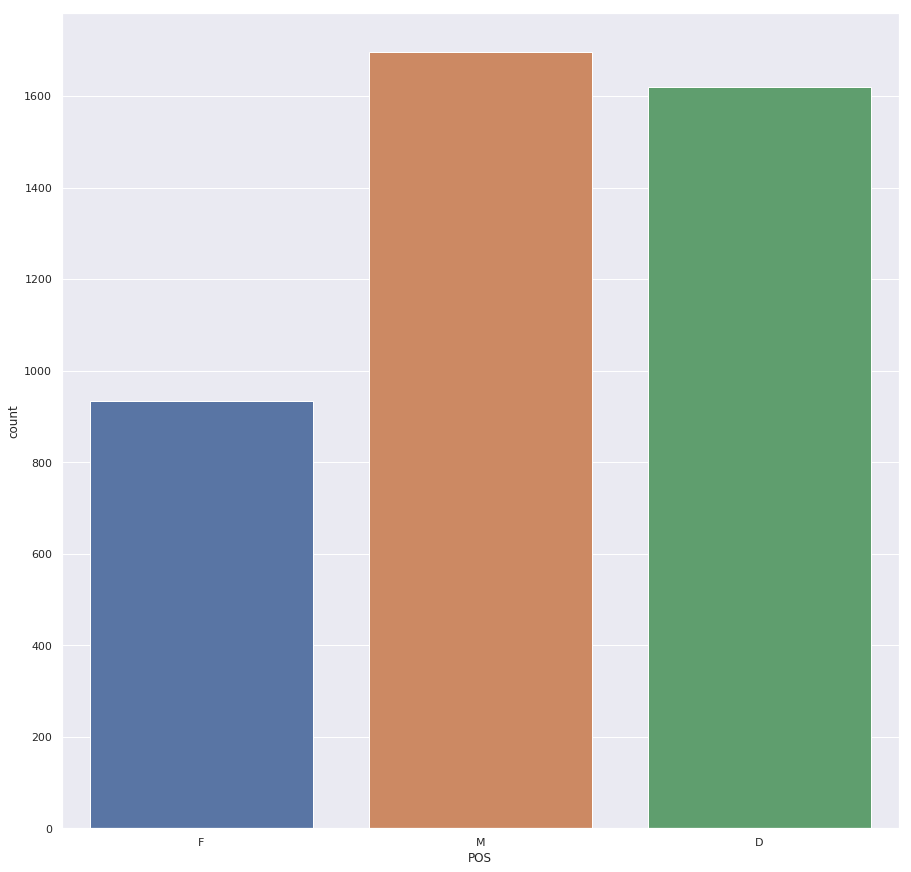

In [475]:
# How many players of each position are represented?
sns.countplot(x="POS", data=reg)

We have roughly the same number of midfielders and defenders, but we have less forwards than midfielders and defenders. This is a natural byproduct of the fact that most soccer teams will put 4 defenders and 4 midfielders on the pitch at any given time but only 2 forwards:

![positions](https://www.sportszion.com/wp-content/uploads/2019/09/Soccer-positions-and-their-importance-on-the-game.png)

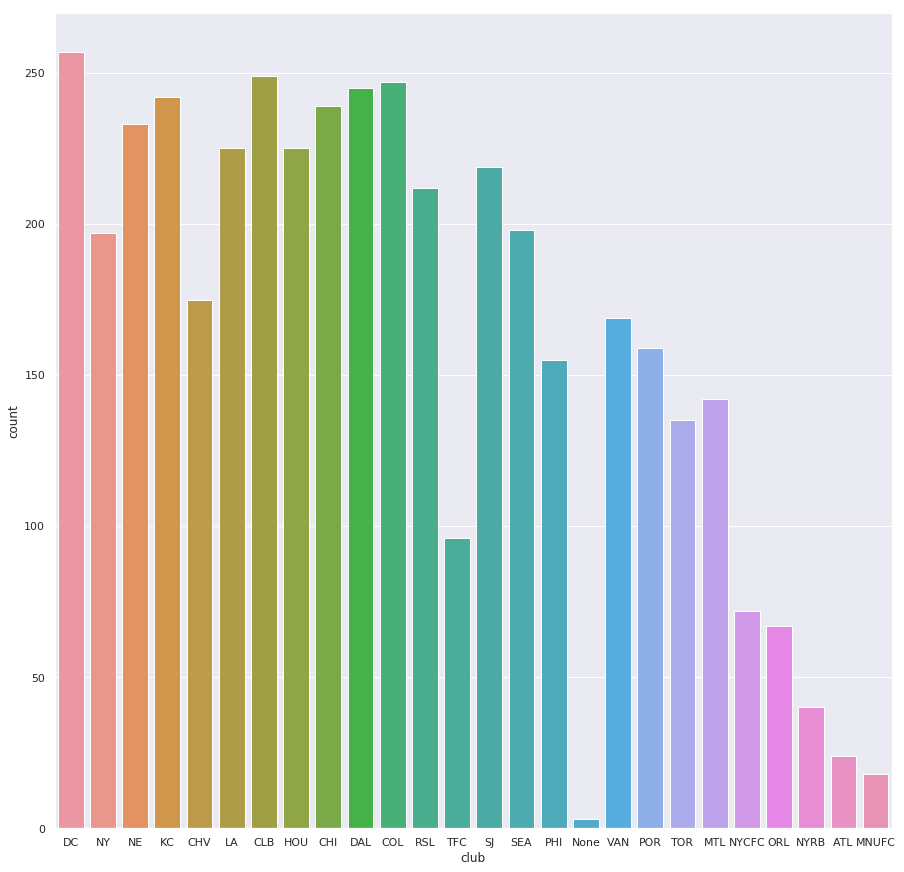

In [476]:
# How many players from each team?
sns.countplot(x="club", data=reg)

Some teams are more represented than others. This could be happening for a lot of reasons: some teams may have higher turnover than others, for example. But most variation is explained by the fact that some teams are simply older than others. The MLS has expanded a lot since its beginning. Atlanta only began playing in 2017, for example, so it makes sense that they're less represented in our dataset. Similarly, New York had one franchise until 2015, when New York City FC entered the league. The New York Red Bulls (designated as NYRB) are actually quite well represented in our dataset, as both NY and the NYRB.

Since NY and NYRB are the same franchise, we'll say that any player who played for "NY" actually played for "NYRB".

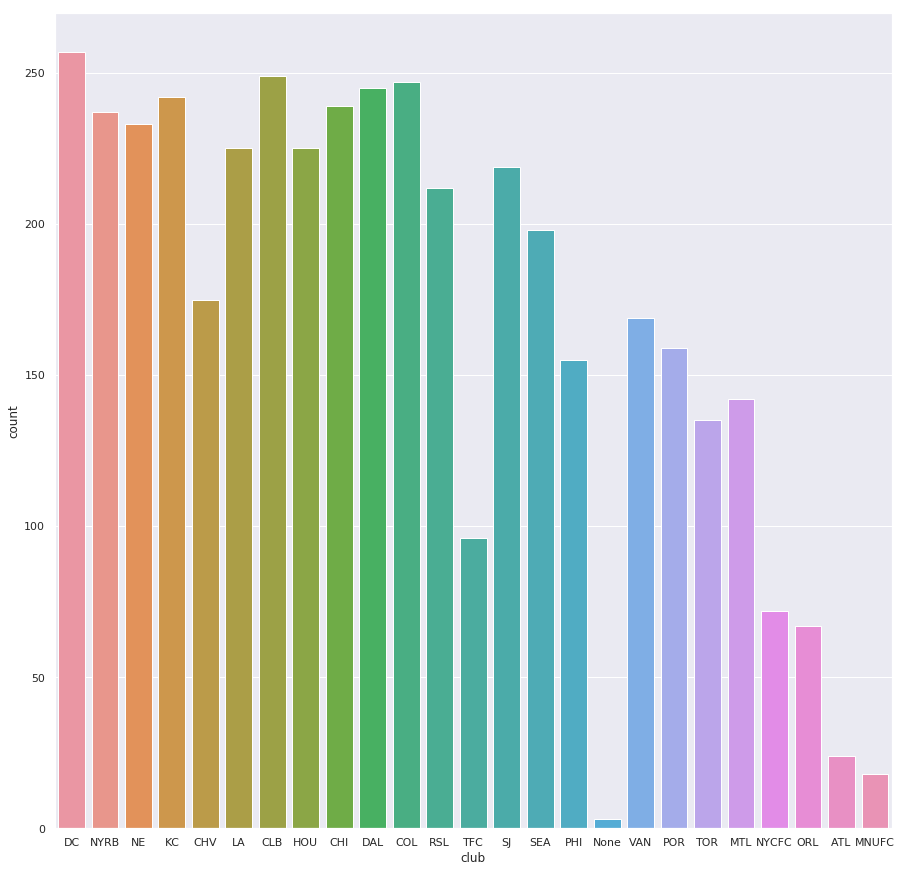

In [477]:
reg["club"] = reg["club"].replace("NY","NYRB")
# Same visualization but corrected
sns.countplot(x="club", data=reg)

Looks better now.

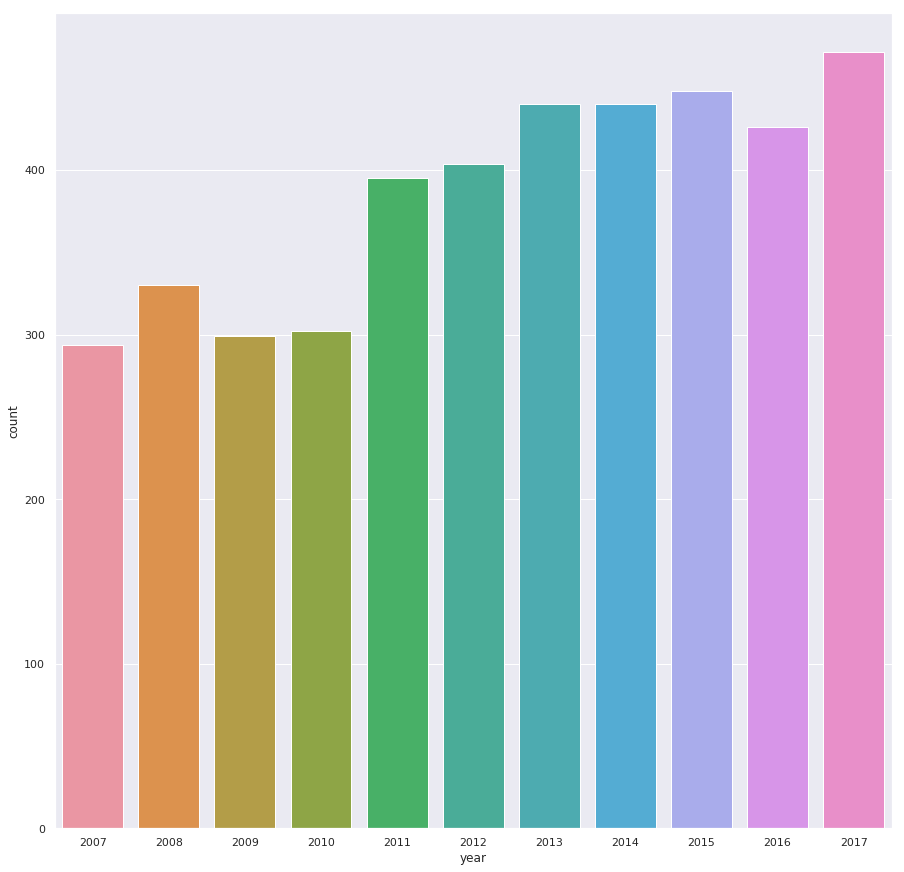

In [478]:
# How many players from each year?
sns.countplot(x="year", data=reg)

Later years are more likely to be represented in our dataset than earlier years. The MLS has grown rapidly since 2007 (adding 9 teams, which is 70% growth over this period) so this makes sense.

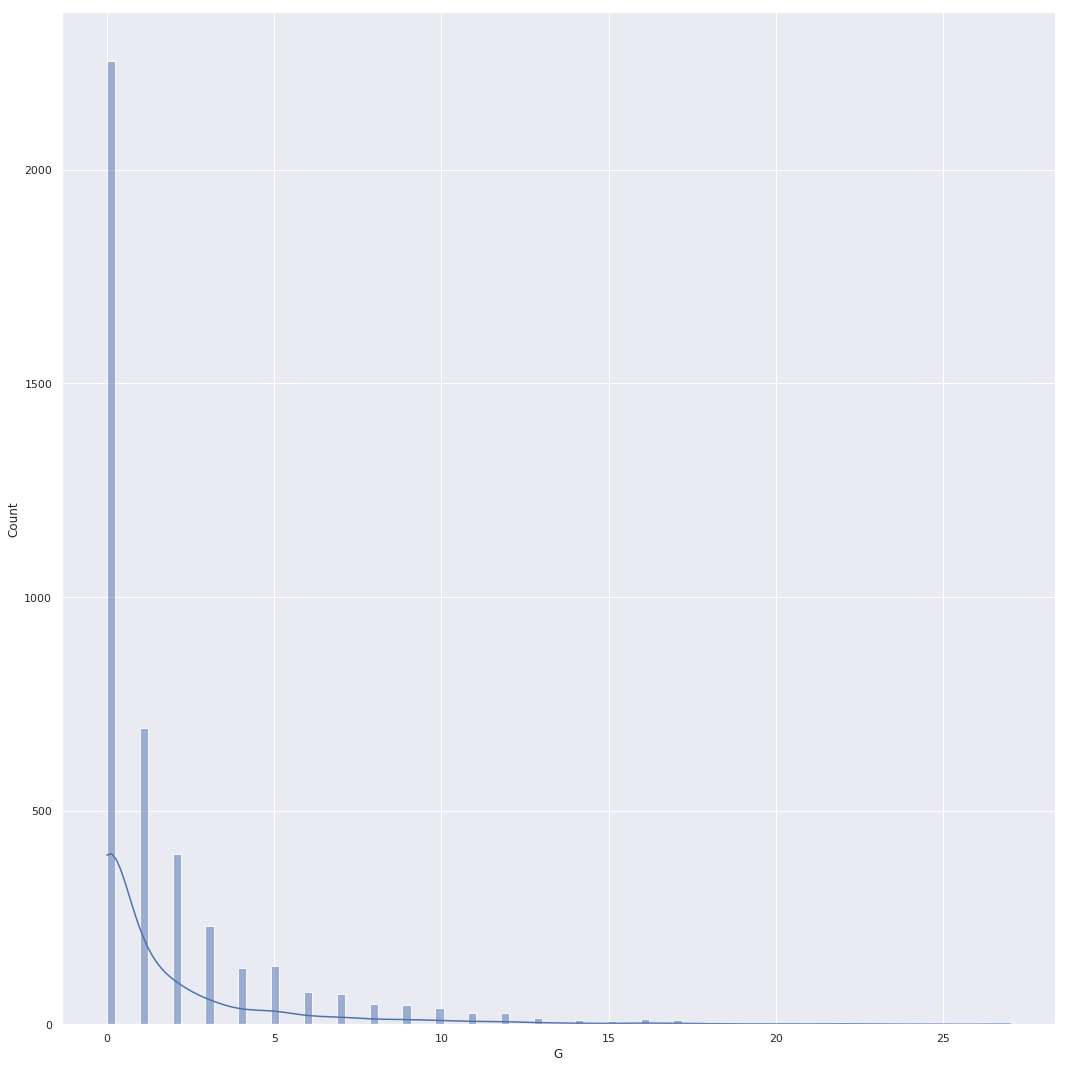

In [479]:
# What's the distribution of goals?
sns.displot(x="G", data=reg, kde=True, height=15, aspect=15/15)

The distribution is clearly very skewed. It may be a good idea to plot it on a log scale:

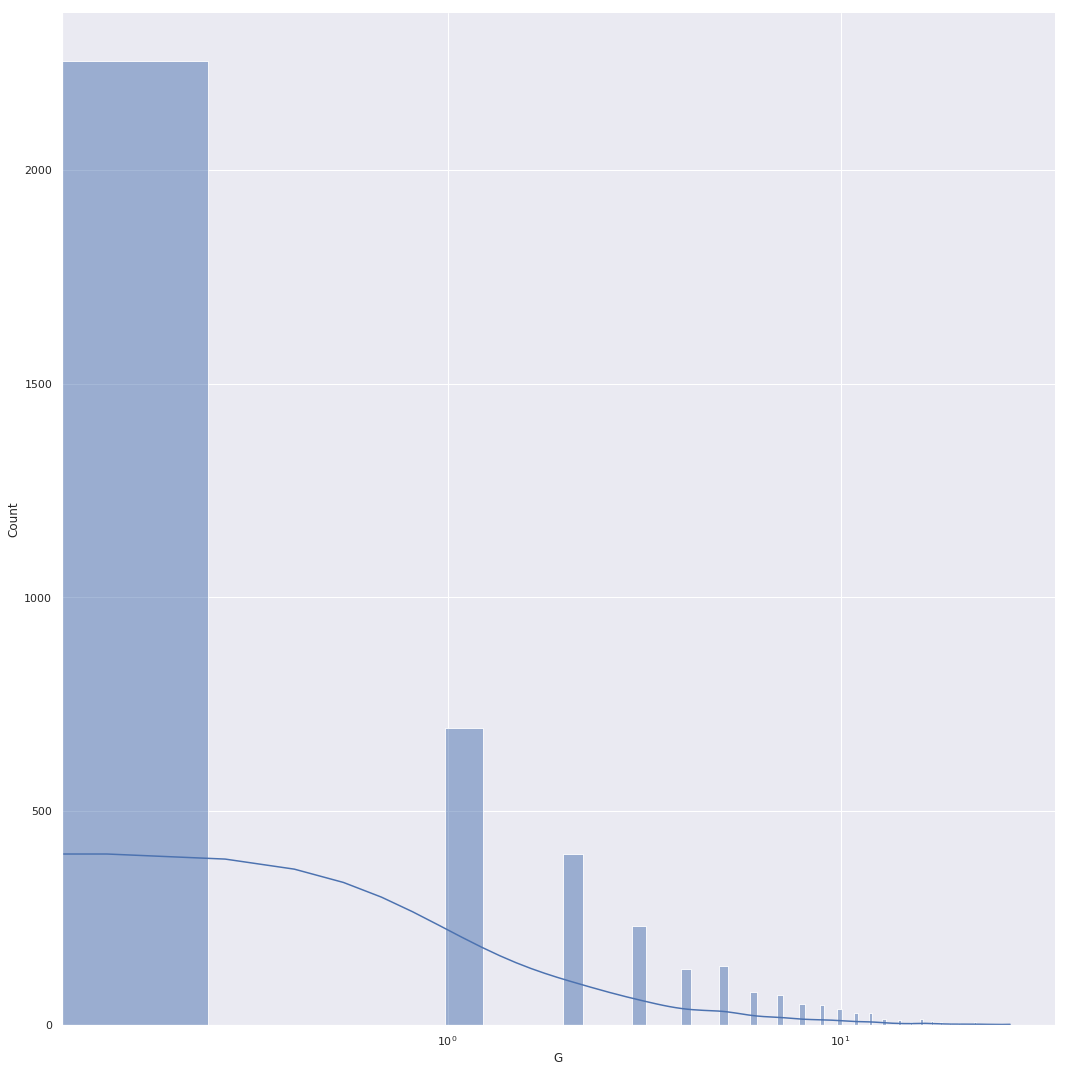

In [480]:
# What's the distribution of goals? but on a log scale.
sns.displot(x="G", data=reg, kde=True, height=15, aspect=15/15)
plt.xscale('log')

Still very skewed. Only a small proportion of players score over 10 goals in a season.

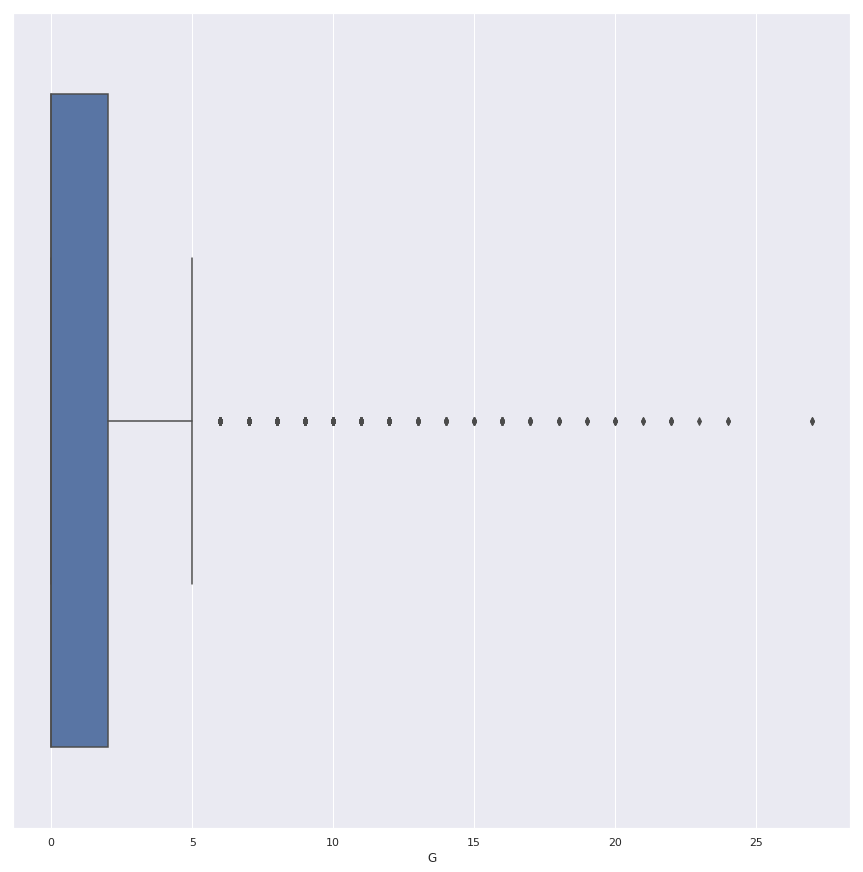

In [481]:
# As a box plot...
sns.boxplot(x="G", data=reg)

75% of players score less than 2 goals a season, but the 5 best score over 20 a season.

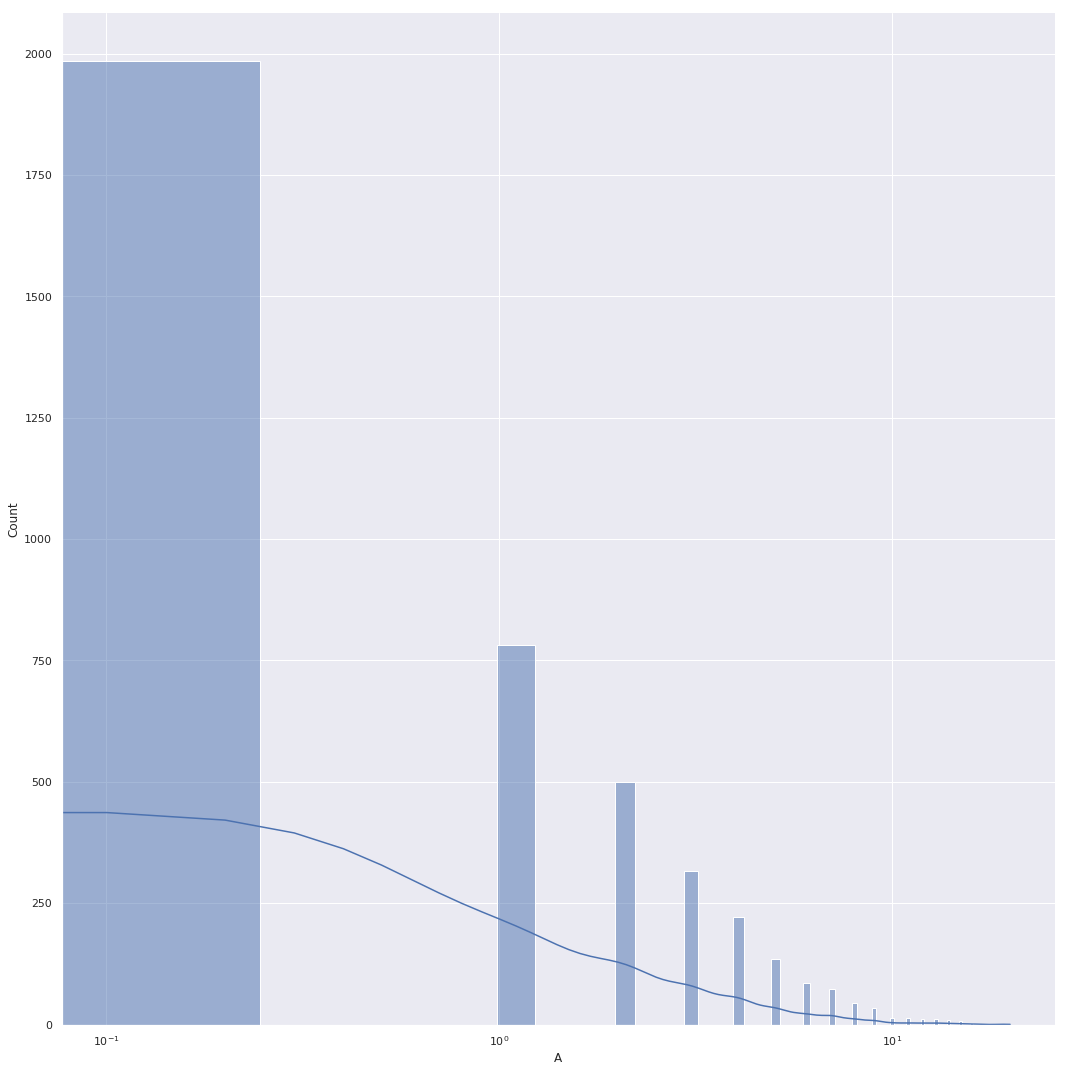

In [482]:
# What's the distribution of assists? but on a log scale.
sns.displot(x="A", data=reg, kde=True, height=15, aspect=15/15)
plt.xscale('log')

The shape is nearly identical to the distribution of goals. The numbers are a bit bigger in absolute terms, probably because up to two players can be credited for an assist. 

Why are both distributions so heavily skewed? Why do a few players score so much and everyone else scores so little? It's hard to say. We'll revisit, but for now we'll just make note of the fact that this distribution is highly asymmetrical.

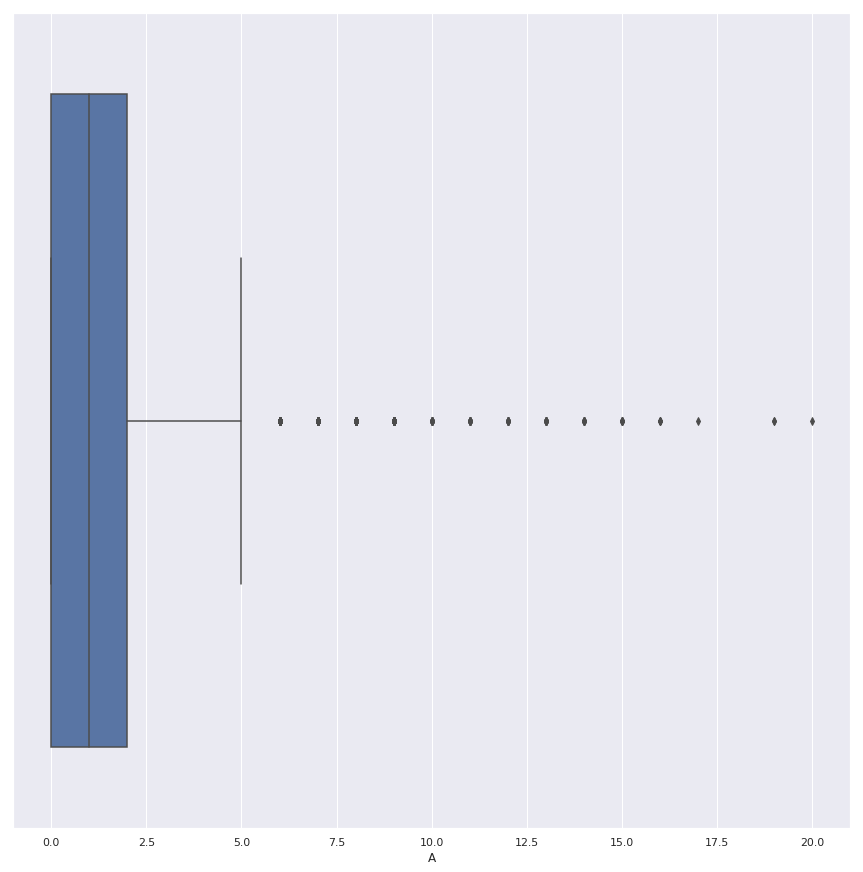

In [483]:
# Boxplot for assists...
sns.boxplot(x="A", data=reg)

If there's >10 outliers, then it's probably not fair to treat those data points as outliers. In other words, we're going to keep the outliers in our dataset.

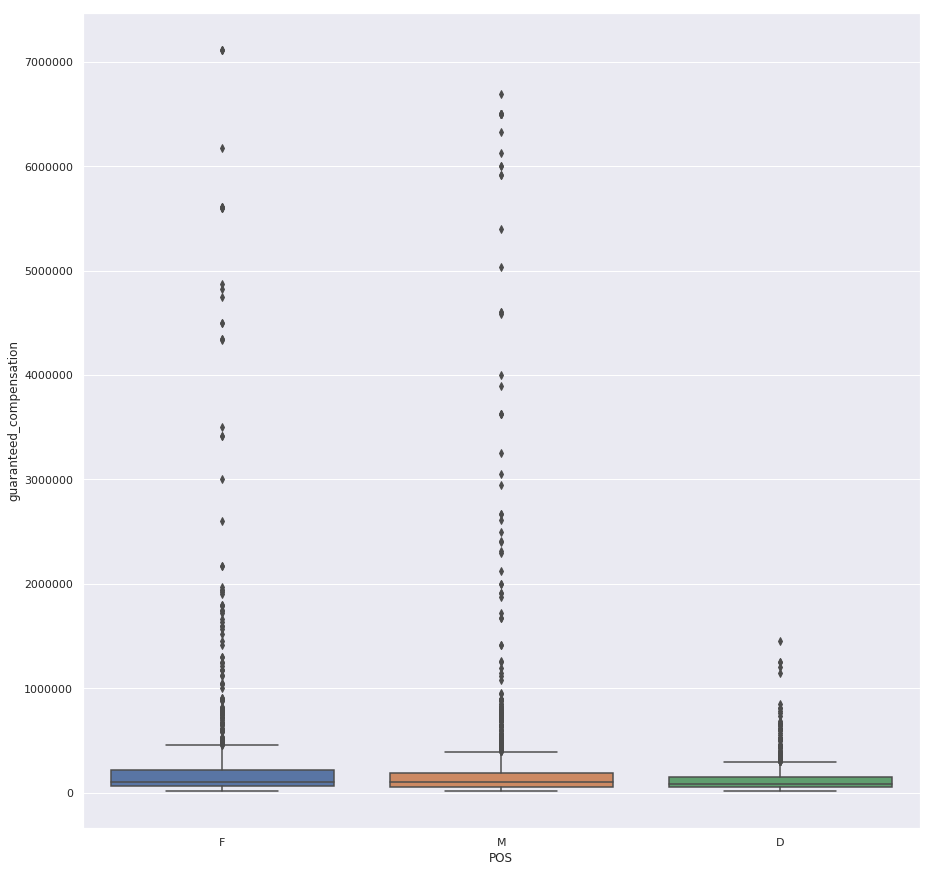

In [484]:
# What's the median salary for each position? The variance?
sns.boxplot(x="POS", y="guaranteed_compensation", data=reg)

You have to feel bad for the defenders here. Only a handful of them make more than >$1,000,000 a year.

This plot seems to provide some evidence for the idea that goals and assists (and other offensive stats) are the primary determinants of a player's salary, since midfielders and forwards are making way more than defenders. 

It's relieving to know that it's not as though defenders are paid based on completely different criterion than forwards and midfielders. It will simplify our analysis to assume this once we get into the machine learning part of things.

Note how wildly asymmetrical these distributions are.

In [485]:
# Who are the top five highest paid players for each position?
# We'll use a utility function here to reduce code reuse.
def findTopFive(pos):
    top_five = reg[reg["POS"] == pos].nlargest(5, 'guaranteed_compensation')
    return top_five
findTopFive('D')

,Player,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,FC,FS,OFF,YC,RC,SOG%,year,Season,club,guaranteed_compensation
4669,Omar Gonzalez,D,30,29,2577,1,3,13,6,1,...,34,16,0,3,0,46.15,2015,reg,LA,1450000.0
3894,Omar Gonzalez,D,22,22,1902,4,2,18,10,1,...,28,19,1,5,1,55.56,2014,reg,LA,1250000.0
5453,Liam Ridgewell,D,22,22,1980,1,0,12,4,1,...,25,30,2,6,0,33.33,2016,reg,POR,1250000.0
3963,Liam Ridgewell,D,15,15,1350,2,1,10,4,0,...,16,14,2,3,0,40.00,2014,reg,POR,1200000.0
4876,Liam Ridgewell,D,32,32,2868,0,1,12,2,0,...,19,25,2,6,1,16.67,2015,reg,POR,1150000.0


In [486]:
findTopFive('M')

,Player,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,FC,FS,OFF,YC,RC,SOG%,year,Season,club,guaranteed_compensation
3806,Clint Dempsey,M,26,23,2132,15,10,113,47,5,...,34,52,12,4,0,41.59,2014,reg,SEA,6695188.75
242,David Beckham,M,5,2,252,0,2,8,0,0,...,2,7,0,0,0,0.00,2007,reg,LA,6500000.04
511,David Beckham,M,25,25,2248,5,10,35,12,1,...,14,37,4,6,0,34.29,2008,reg,LA,6500000.04
1099,David Beckham,M,11,11,889,2,3,19,9,2,...,14,9,0,2,1,47.37,2009,reg,LA,6500000.04
1546,David Beckham,M,7,5,466,2,1,9,6,1,...,4,6,0,2,0,66.67,2010,reg,LA,6500000.04


In [487]:
findTopFive('F')

,Player,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,...,FC,FS,OFF,YC,RC,SOG%,year,Season,club,guaranteed_compensation
4420,Sebastian Giovinco,F,33,32,2775,22,16,181,73,7,...,43,90,34,4,0,40.33,2015,reg,TOR,7115555.67
5142,Sebastian Giovinco,F,28,28,2418,17,15,177,59,4,...,32,69,29,3,0,33.33,2016,reg,TOR,7115555.67
5815,Sebastian Giovinco,F,25,25,2057,16,6,128,52,4,...,30,54,10,4,0,40.62,2017,reg,TOR,7115555.67
3822,Jermain Defoe,F,19,17,1529,11,2,58,25,5,...,22,23,25,5,0,43.10,2014,reg,TOR,6180000.00
4426,David Villa,F,30,29,2514,18,8,138,64,6,...,29,49,47,4,0,46.38,2015,reg,NYCFC,5610000.00


Not a whole lot of suprises here -- the highest paid payers are some big American names (Clint Dempsey) and some famous players from overseas who were wooed over to play in the MLS for a little bit (David Beckham, Sebastian Giovinco). It's worth noting that players may appear more than once in the top five if they have a long-term lucrative contract, as Sebastian Giovinco did.

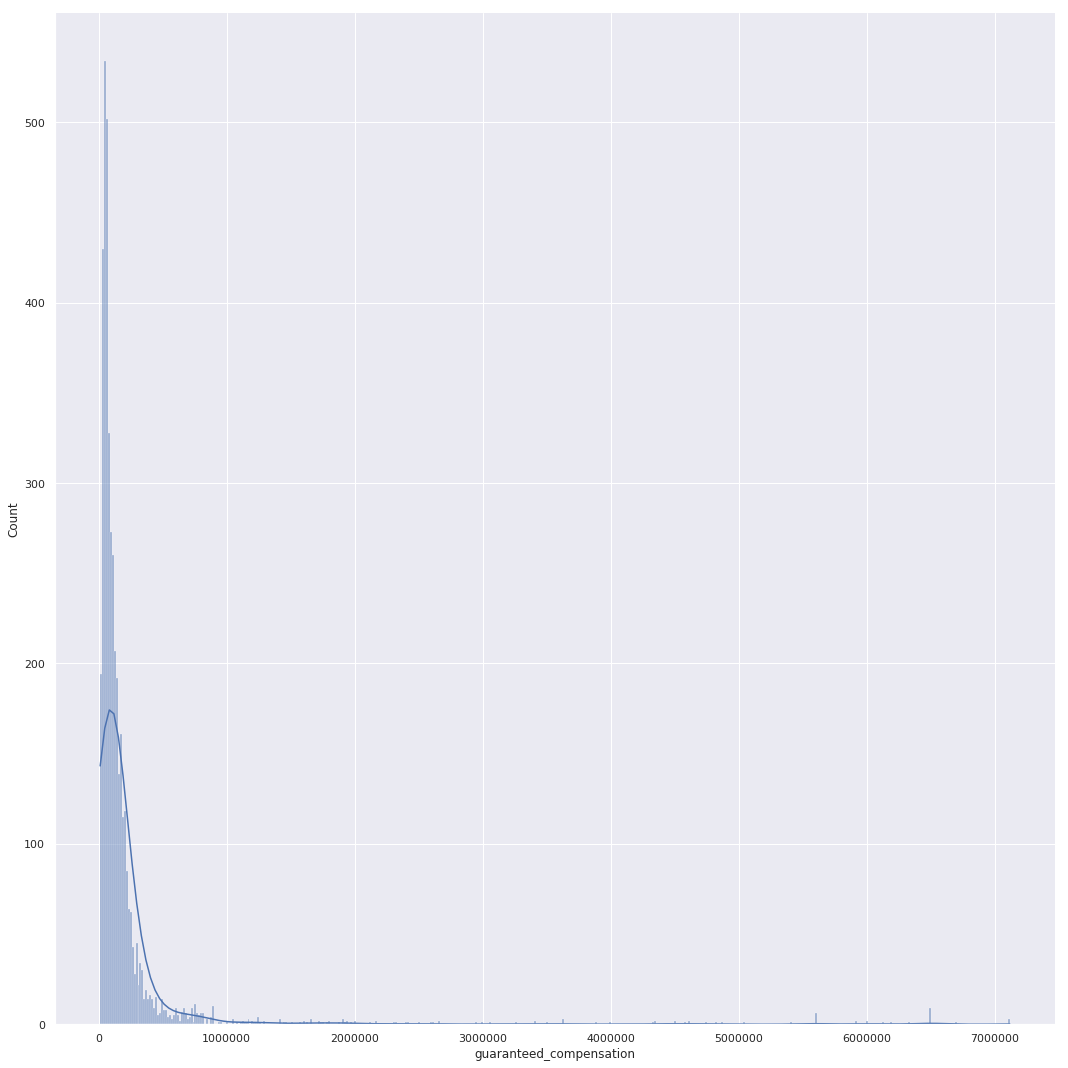

In [488]:
# How are salaries distributed?
sns.displot(x="guaranteed_compensation", data=reg, kde=True, height=15, aspect=15/15)

This distriution is ridiculously asymmetrical, much more so than the distributions for goals and assists, which were highly asymmetrical themselves. Let's see how it looks on a log scale:

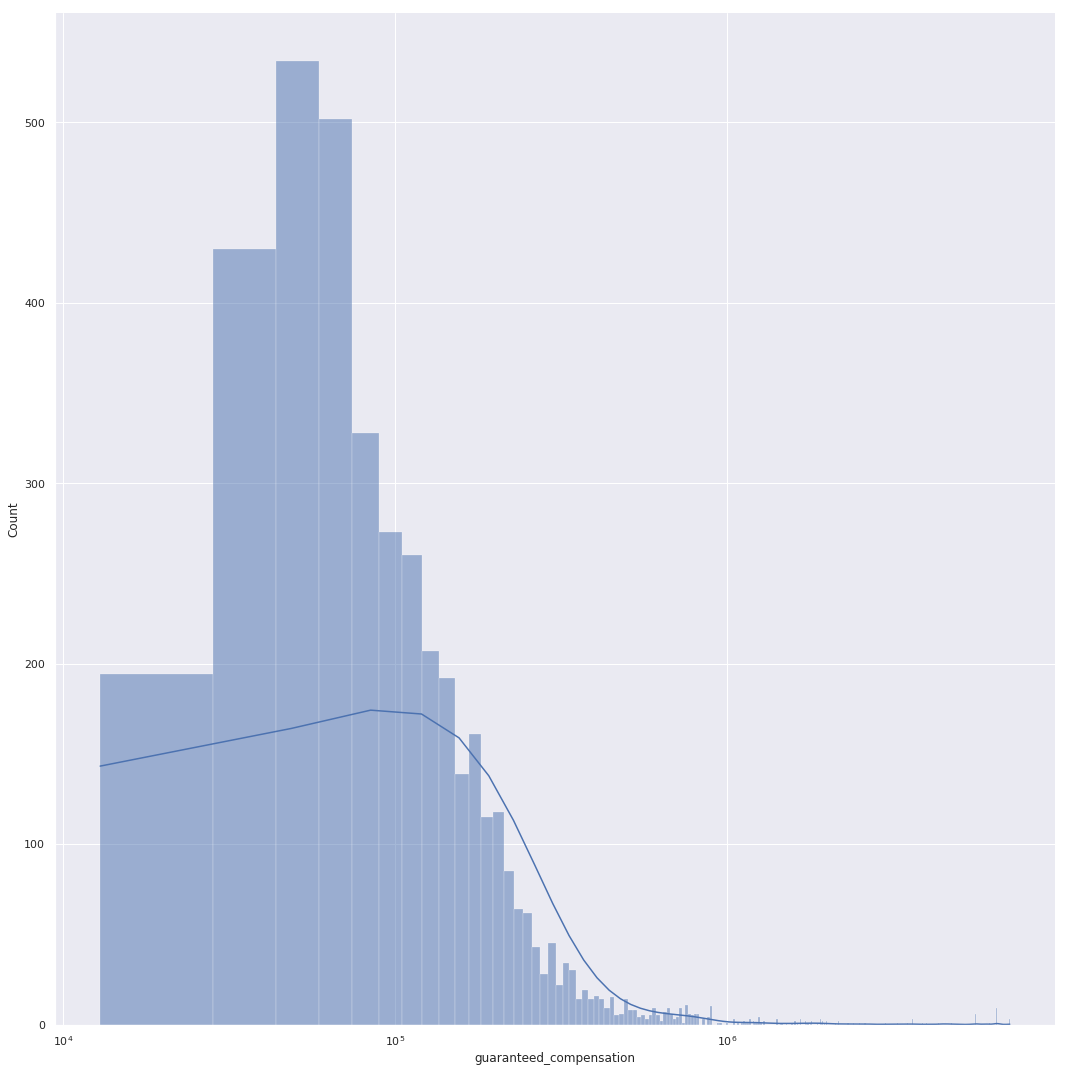

In [489]:
sns.displot(x="guaranteed_compensation", data=reg, kde=True, height=15, aspect=15/15)
plt.xscale('log')

Still ridicuously asymmetrical. We should consider what could possibly be causing these asymmetries.

Many things in nature are fit well by a normal distribution. Heights, blood pressure, measurement error, etc. This can be attributed to the central limit theorem. [When independent random variables are added, their sum tends toward a normal distribution even if the original variables themselves are not normally distributed.](https://en.wikipedia.org/wiki/Central_limit_theorem) So any number that can be viewed as the sum/average of a lot of small random variables can be fit well by a normal distribution. 

Different generative mechanisms can lead to much different distributions. For example, the product / geometric average of a lot of small random variables leads to a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

## Power Laws

*You can find out more about power laws at this [link](https://www.cs.cornell.edu/home/kleinber/networks-book/networks-book-ch18.pdf) and the [paper that accompanied powerlaw's release.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777)* 

Power laws are heavy-tailed (defined as a distribution with a heavier-tail than the exponential distribution) distributions that occur very often in the real world. In simple terms, this means that there are way more large values in a data than can possibly be explained by a normal distribution. Income is distributed according to a power law, so it's fair to guess that soccer player's pay is also distributed according to a power law.

Power laws have some very interesting mathematical properties. If the parameter alpha in the equation below is < 3, then the distribution has no standard deviation. If the parameter alpha in the equation below is < 2, then it has no central tendency.

Why do we care? If we know that compensation follows a power law then that may shed some light on the generative mechanisms that are causing such discrepencies in pay. The first link I attached states that *"power laws arise from the feedback introduced by correlated decisions across a population."* For example, the popularity of websites and academic papers follow a power law, since they're caused by "decision-making cascades" -- people have the tendency to copy decisions made by people who acted before them. 

If a power law fits this data really well, then does that mean that a good degree of the variation in soccer player pay is caused by a similar "decision-making cascade"? What would that "decision-making cascade" be? Maybe it's the result of teams outbidding each other for top players.  Maybe it's something else. It's an interesting enough question (and the powerlaw library makes it easy enough to answer) that we'll use a few lines of code to investigate.

Using the powerlaw library is very easy and you should be able to get the gist of it just by looking at the next few lines.

![powerlaw_graph](https://miro.medium.com/max/700/1*ijiaYV3jPl51vkOSV4tdRg.png)
![powerlaw_equation](https://miro.medium.com/max/530/1*sShwUUlvLsr7QY3XS5GsHQ.png)

In [490]:
# Fit the data to a power law
fit = powerlaw.Fit(df.guaranteed_compensation)

Calculating best minimal value for power law fit


In [491]:
# Print out the optimal value of x_min after which the powerlaw relation begins...
fit.xmin

263600.0

In [492]:
# Print out value of the parameter alpha as described in the equation above
fit.power_law.alpha

2.0957840338865603

In [493]:
# What is the distance between the data and the fit?
fit.power_law.D

0.04207909594134507

The distance between the data and the fit is small, indicating that a power law might be a good fit. Let's compare it to some other distributions to really see.

The higher the first value in the tuple returned by the distribution_compare method, the more likely it is that first distribution fits the data than the second one. Similarly, large negative values indicate that it's likely that the second distribution is a good fit for the data. The second value in the tuple is the p-value -- smaller values mean that the package is sure that one distribution is better than the other. You can find more rigorous definitions at the [paper that accompanied powerlaw's release.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777)

The power-law absolutely must fit better than an exponential fit if it has any hope at being accurate, since otherwise the tail isn't even heavy enough to be considered a heavy-tail:

In [494]:
fit.distribution_compare('power_law', 'exponential')

(307.130482101965, 5.029675800855953e-46)

In [495]:
fit.distribution_compare('power_law', 'stretched_exponential')

(2.0636498108777452, 0.3160046535476352)

In [496]:
fit.distribution_compare('truncated_power_law', 'stretched_exponential')

(6.632636956108646, 5.349697282362818e-15)

A truncated power law seems to fit the data way better than any kind of exponential fit does. That's a good sign. Now let's compare the distribution to what is usually the main competitor to a power-law distribution to describe a heavy-tailed distribution, a lognormal distribution:

In [497]:
fit.distribution_compare('power_law', 'lognormal_positive') 

(0.49551714932442437, 0.6439282777438966)

In [498]:
fit.distribution_compare('power_law', 'lognormal')

(-0.15051359002397469, 0.6581249336263886)

In [499]:
fit.distribution_compare('power_law', 'truncated_power_law')

Assuming nested distributions


(-4.568987145230979, 0.0025035813565522647)

In [500]:
fit.distribution_compare('truncated_power_law', 'lognormal')

(4.418473555206981, 0.0001899817766054668)

A power law seems to fit the data signficantly better than even a lognormal distribution. With an alpha value of ~2.09, we can't describe the distribution as having any meaningful standard deviation and we should show some caution when talking about its central tendency, since it is right around 2.

This has a practical implication for us going forward as we begin the machine learning portion of this tutorial: be skeptical of regression analysis approaches, unless if we transform the data as shown [here](http://pages.stat.wisc.edu/~ifischer/Intro_Stat/Lecture_Notes/APPENDIX/A4._Regression_Models/A4.1_-_Power_Law_Growth.pdf).

## Analysis! (With machine learning)
We understand a lot about the data we're working with now. We're in a good position to answer our original questions: what features are most important in determining a soccer player's salary, and can we effictively predict a soccer player's salary?

We can use *feature selection* techniques to determine what features most strongly predict a soccer player's salary. [Inspired by this article,](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e) we'll use the following techniques to determine which features have the strongest relationship with a player's salary:

<ol>
<li>Univeriate Selection</li>
<li>Feature Importance</li>
<li>Correlation Matrix with Heatmap</li>
</ol>

Machine learning approaches work best when the training dataset includes a full range of feature combinations. That way our model will be effective at determining how each feature affects a player's compensation.

[Machine Learning for Absolute Beginners](https://www.amazon.com/Machine-Learning-Absolute-Beginners-Introduction/dp/152095140X/ref=asc_df_152095140X/?tag=hyprod-20&linkCode=df0&hvadid=312118197030&hvpos=&hvnetw=g&hvrand=8600545563709390185&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9007733&hvtargid=pla-313514366158&psc=1) by Oliver Theobald recommends that a basic machine learning model contains ten times as many data points as total number of features. Right now, our dataset is small in absolute size (at 4250 rows) but it does meet this criteria, since we have only 25 features. We'll drop any rows that interfere with our ability to fit machine learning models to our data but so long as this holds we should be ok.

For datasets that have less than 10,000 samples, Theobald recommends using clustering and dimensionality reduction algorithms. He recommends regression analysis algorithms for larger dataframes (10,000 <= n <= 100,000). This is fine for us,since as we said earlier we need to be cautious about applying regression analysis when the dependent variable (compensation) is distributed according to a power law. 



### Univariate feature selection
We'll follow along with the documentation [here.](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

Univariate feature selection selects the most predictive features through the use of univariate statistical tests.

Our task is fundamentally a regression task -- we seek to predict numeric scores. So as the scikit-learn documentation suggests, we'll use F-test and mutual information methods. F-tests estimate the degree of linear dependency between two random datasets, which worries me since our dependent variable is decidedly nonlinear. Mutual information methods can capture any kind of dependency but require a decent number of samples to be accurate, which is bad since our dataset is pretty small.

We'll use both methods and compare to see what the most predictive features are.

In [501]:
# We'll go ahead and drop the Season value, which is useless to us at this point
reg.drop(["Season"], axis=1, inplace=True)
describe(reg)

This dataframe has columns: Index(['Player', 'POS', 'GP', 'GS', 'MINS', 'G', 'A', 'SHTS', 'SOG', 'GWG',
       'GWA', 'FC', 'FS', 'OFF', 'YC', 'RC', 'SOG%', 'year', 'club',
       'guaranteed_compensation'],
      dtype='object')
This data frame has 4250 rows


,Player,POS,GP,GS,MINS,G,A,SHTS,SOG,GWG,GWA,FC,FS,OFF,YC,RC,SOG%,year,club,guaranteed_compensation
0,Luciano Emilio,F,29,28,2410,20,1,79,47,4,1,35,39,21,2,0,59.49,2007,DC,293125.0
2,Juan Pablo Angel,F,24,24,2125,19,5,97,53,5,2,31,20,42,2,1,54.64,2007,NYRB,1593750.0
4,Taylor Twellman,F,26,25,2283,16,3,90,55,5,1,13,41,21,2,0,61.11,2007,NE,350008.0
6,Eddie Johnson,F,24,24,2149,15,6,75,43,6,2,21,57,50,6,0,57.33,2007,KC,875000.0
8,Maykel Galindo,F,28,24,2021,12,5,55,28,5,3,44,53,30,6,0,50.91,2007,CHV,72500.0


In [502]:
# Code to clean dataset of NaN instances
def clean_dataset(df):
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [503]:
# Create a version of reg that's suitable for ML algorithms
# We need to drop the name value for now
reg_ML = reg.drop(["Player"], axis=1)
# Get dummy values of categorical variables so that we can easily plug our data into SciKit learn
reg_ML = pd.get_dummies(reg_ML)
clean_dataset(reg_ML)
reg_ML = reg_ML.reset_index()
reg_ML = reg_ML.drop(["index"], axis=1)
describe(reg_ML)

This dataframe has columns: Index(['GP', 'GS', 'MINS', 'G', 'A', 'SHTS', 'SOG', 'GWG', 'GWA', 'FC', 'FS',
       'OFF', 'YC', 'RC', 'SOG%', 'year', 'guaranteed_compensation', 'POS_D',
       'POS_F', 'POS_M', 'club_ATL', 'club_CHI', 'club_CHV', 'club_CLB',
       'club_COL', 'club_DAL', 'club_DC', 'club_HOU', 'club_KC', 'club_LA',
       'club_MNUFC', 'club_MTL', 'club_NE', 'club_NYCFC', 'club_NYRB',
       'club_None', 'club_ORL', 'club_PHI', 'club_POR', 'club_RSL', 'club_SEA',
       'club_SJ', 'club_TFC', 'club_TOR', 'club_VAN'],
      dtype='object')
This data frame has 3460 rows


,GP,GS,MINS,G,A,SHTS,SOG,GWG,GWA,FC,...,club_None,club_ORL,club_PHI,club_POR,club_RSL,club_SEA,club_SJ,club_TFC,club_TOR,club_VAN
0,29,28,2410,20,1,79,47,4,1,35,...,0,0,0,0,0,0,0,0,0,0
1,24,24,2125,19,5,97,53,5,2,31,...,0,0,0,0,0,0,0,0,0,0
2,26,25,2283,16,3,90,55,5,1,13,...,0,0,0,0,0,0,0,0,0,0
3,24,24,2149,15,6,75,43,6,2,21,...,0,0,0,0,0,0,0,0,0,0
4,28,24,2021,12,5,55,28,5,3,44,...,0,0,0,0,0,0,0,0,0,0


In [504]:
# Utility function to put SelectKBest results in a readable format
def kBest(fit, X):
    scores = pd.DataFrame(fit.scores_)
    cols = pd.DataFrame(X.columns)
    combined = pd.concat([cols, scores], axis=1)
    combined.columns = ["Feature", "Score"]
    return combined.nlargest(10, 'Score')

In [505]:
# Set independent variables 
X = reg_ML.loc[:, reg_ML.columns != 'guaranteed_compensation']
# Set dependent variable
y = reg_ML['guaranteed_compensation']

In [506]:
# Fit f_regression model
f_test_results = SelectKBest(score_func=f_regression, k=10)
fit = f_test_results.fit(X, y)
kBest(fit, X)

,Feature,Score
3,G,457.691816
5,SHTS,451.616350
6,SOG,403.311224
4,A,318.907212
7,GWG,308.503087
8,GWA,180.296115
11,OFF,161.357512
10,FS,158.146575
1,GS,74.472417
2,MINS,71.896782


In [507]:
# Fit mutual info regression model
mutual_info_results = SelectKBest(score_func=mutual_info_regression, k=10)
fit = mutual_info_results.fit(X, y)
kBest(fit, X)

,Feature,Score
15,year,0.411701
2,MINS,0.109341
10,FS,0.103177
5,SHTS,0.102663
6,SOG,0.096148
0,GP,0.091924
1,GS,0.086884
4,A,0.075986
7,GWG,0.066230
9,FC,0.066095


#### Results
The f_test gave results that are intuitive and in-line with our exploratory data analysis: goals are the most important determinant of a player's salary, and assists are really important too. One is tempted to believe that the importance of SHTS and SOG on a player's salary is caused by the effect that players who shoot more are more likely to score, or at least to be seen as great shooters by their teammates. Game winning goals and game winning assists are also important determinants of a player's salary. Suprisingly, the number of offsides penalities a player incurs has a big effect on his salary. I wonder if the effect is positive or negative. If it's positive, there's a simple explanation: players who are offsides a lot are simply more likely to create more offensive opportunites, some of which may occasionally go wrong.

The results given by the mutual info fit don't look as good. Our dataset is relatively small and it probably didn't work as well as it would have with more data. 

One counterintuitive result here given in both models is that fouls sustained has a large effect on a player's salary. I'd bet that this is because player's who sustain fouls are more likely to get penalty kicks and are therefore more likely to score goals.

### Feature Importance

Decision tree based regressors can be very effective. Scikit has an ["extra-trees" regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) that "fits a number of randomized decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting". So a concerted effort is made to combat the main drawback of using a decision tree, overfitting.

It will be interesting to see if this decision tree based regressor predicts salaries well, and to see what kind of hyperparameter tweaks could boost its performance. But we'll answer these questions later. For now, we simply seek to understand what kind of features the ExtraTreeRegressor finds to be important to the dataset. We'll play around with some values of max_depth (one of the most important hyperparameters in this model) to see how that affects things.

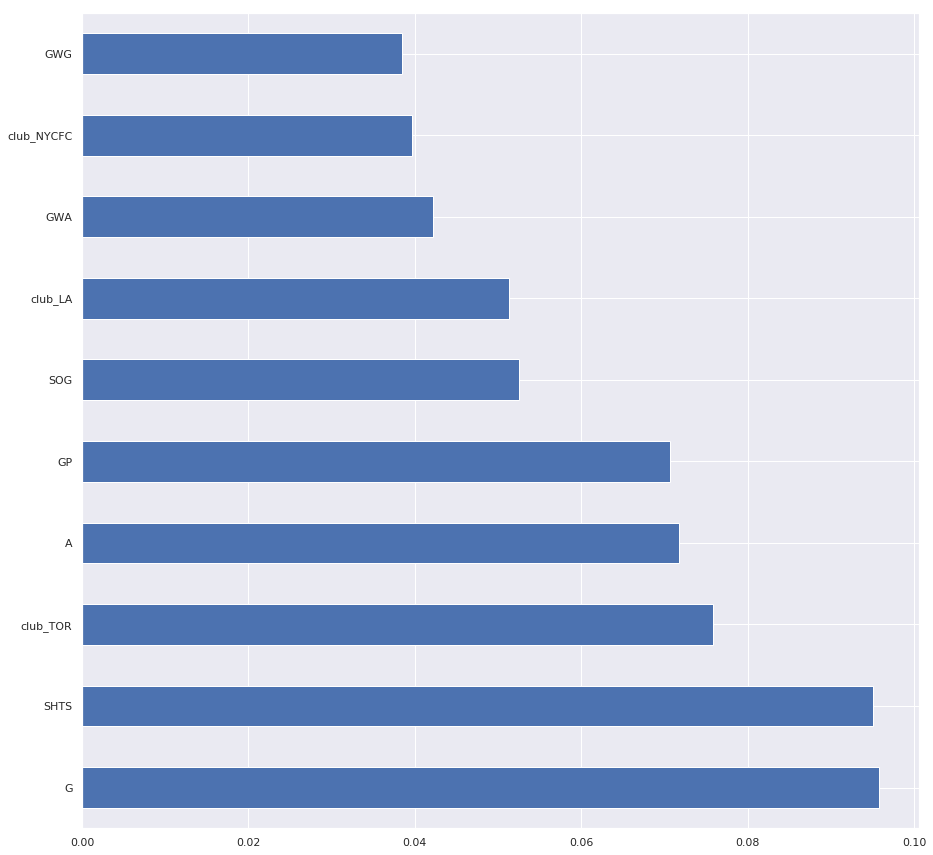

In [508]:
# Utility function to plot most important features of model
def plot_importance(model, X):
    df = pd.Series(model.feature_importances_, index=X.columns)
    df.nlargest(10).plot(kind='barh')
    plt.show()
model = ExtraTreesRegressor()
model.fit(X, y)
plot_importance(model, X)

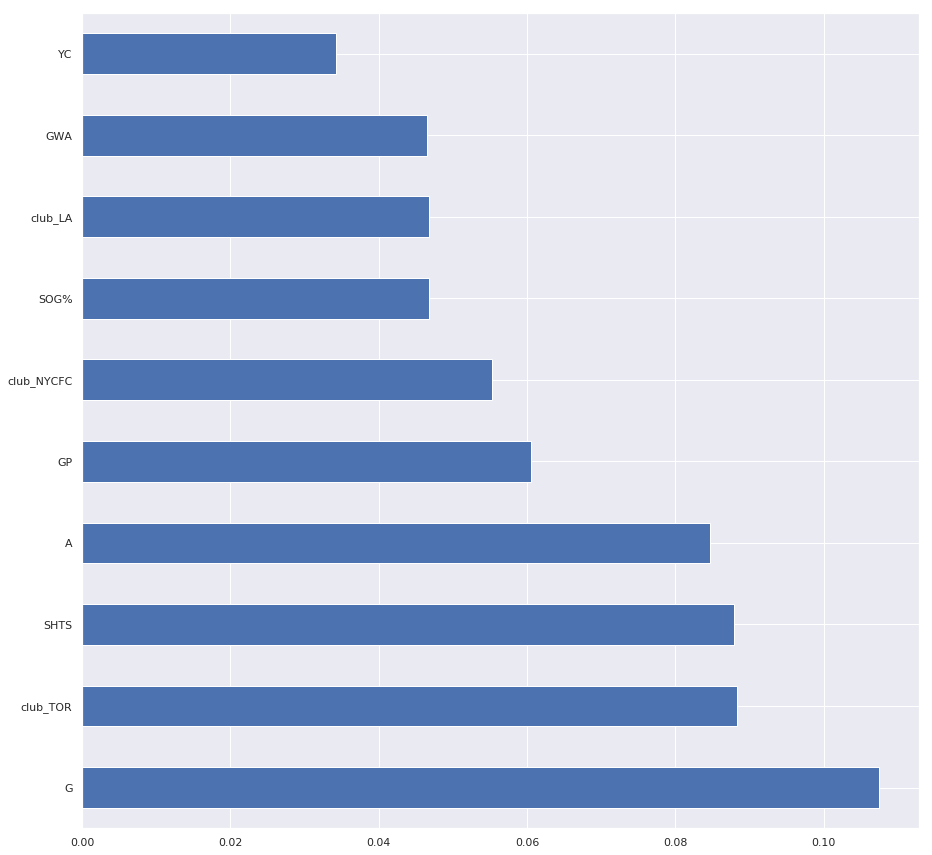

In [509]:
# Play around with hyperparameter max_depth...
model = ExtraTreesRegressor(max_depth=50)
model.fit(X, y)
plot_importance(model, X)

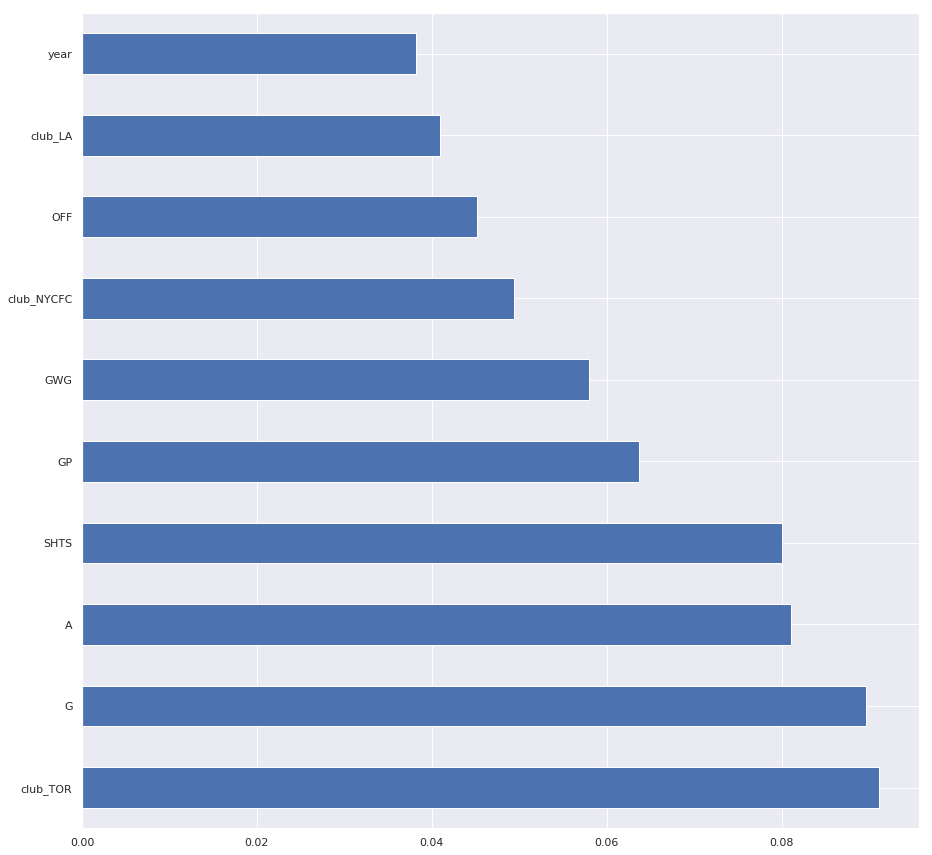

In [510]:
# Play around with hyperparameter max_depth...
model = ExtraTreesRegressor(max_depth=25)
model.fit(X, y)
plot_importance(model, X)

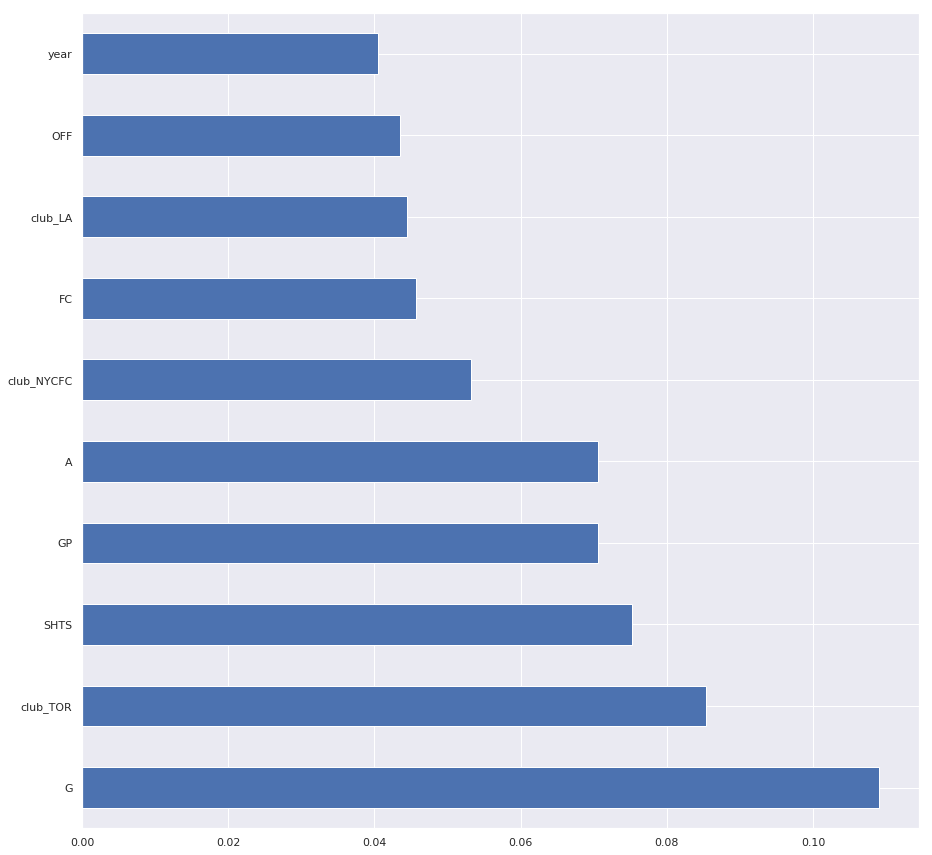

In [511]:
# Play around with hyperparameter max_depth...
model = ExtraTreesRegressor(max_depth=38)
model.fit(X, y)
plot_importance(model, X)

#### Analysis
The fundamental conclusions of the decision tree are the same as the f_test from above. Goals and shots taken are really important determinants of a player's salary. So are the number of assists he has. Interestingly, the decision tree model picks up on the importance of club. At every level of max_depth I tried, playing in a big market is a huge determinant of a player's salary: playing for Toronto, LA, or NYCFC seems to be important. I worry about the effect of outliers here: does LA pay everyone a lot, or is David Beckham just dominating the model?

In many ways, the decision tree model gives more intuitive results than the f_test did. It makes a lot of sense that the club a player plays for would have a bigger impact on his salary than the number of fouls he sustains. I'm excited to see if the decision tree predicts a player's salary well...

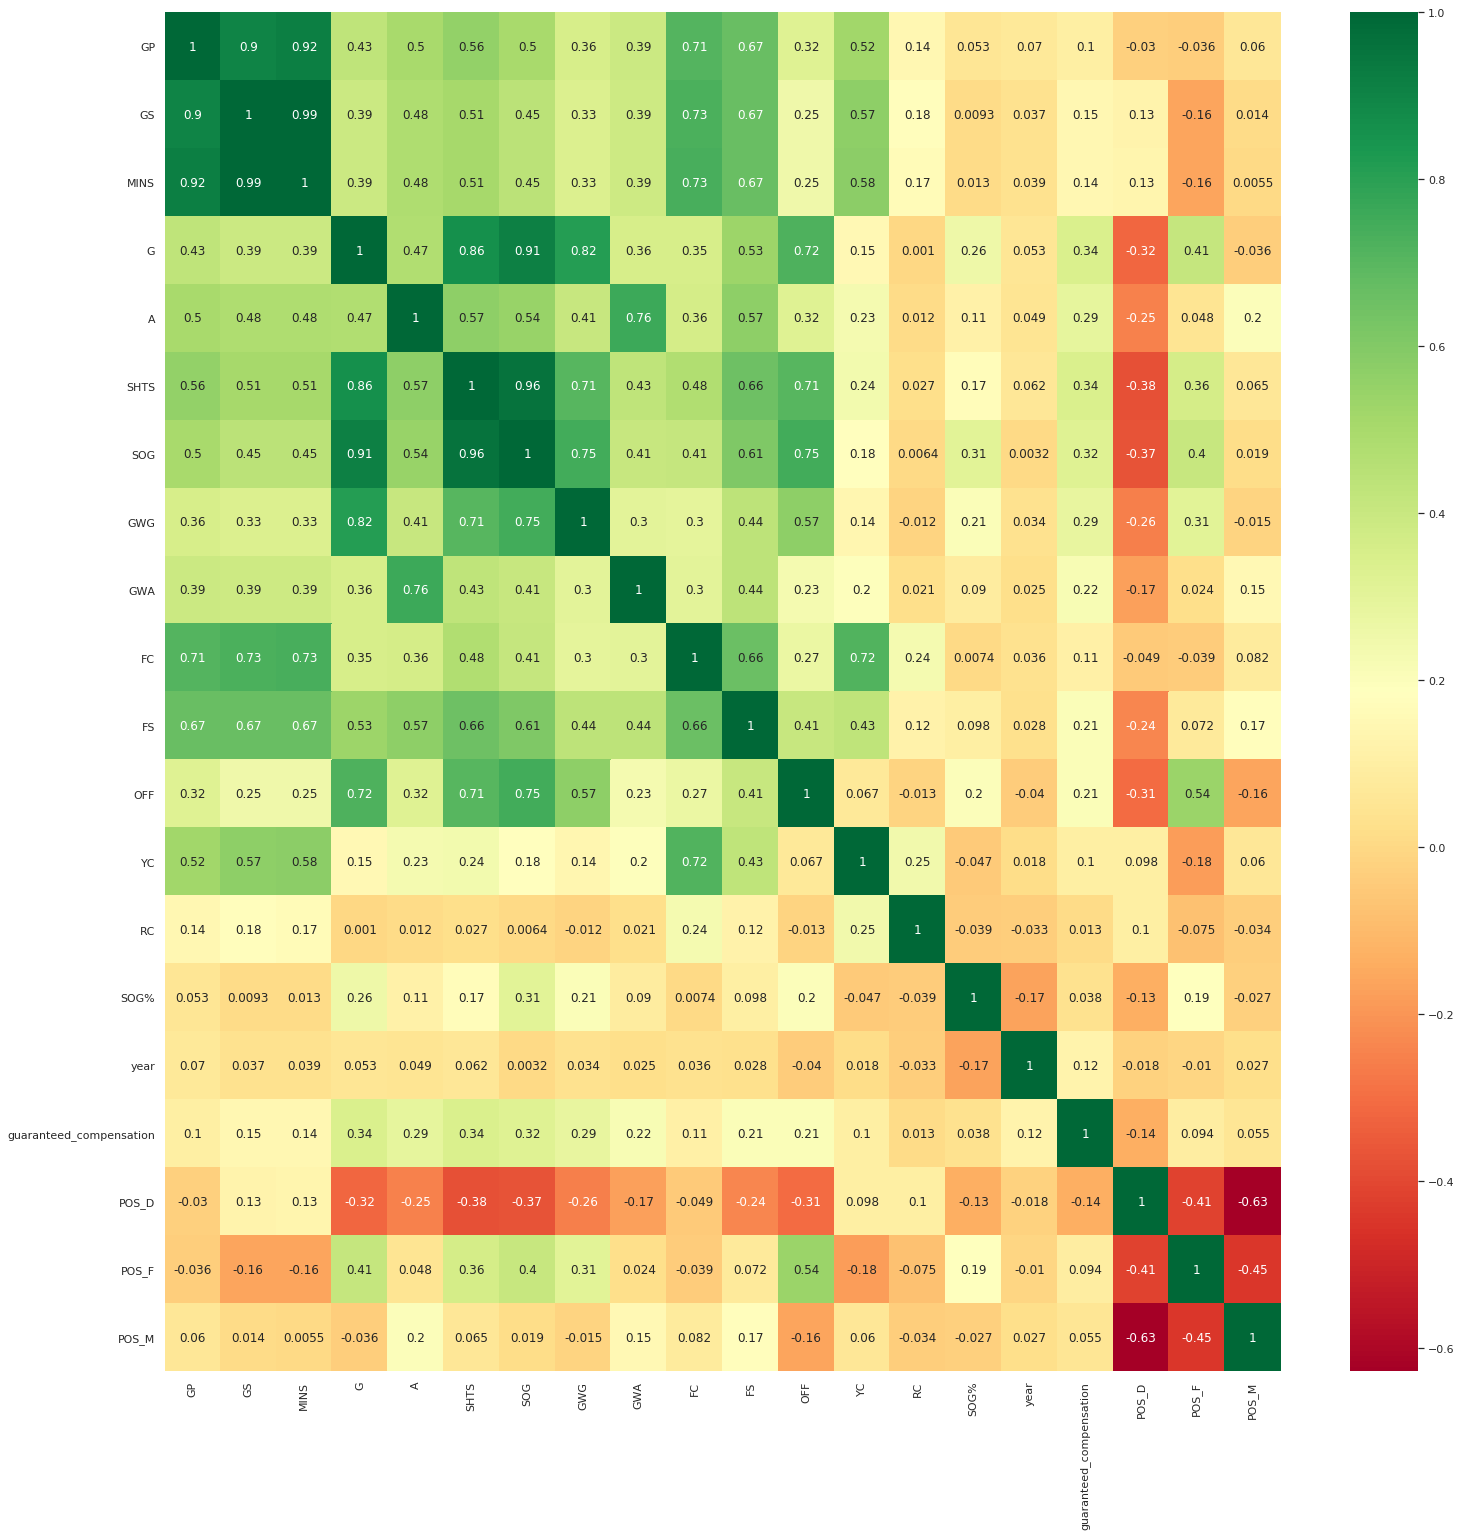

In [512]:
sns.set(rc={'figure.figsize':(25,25)})
# There's simply too many teams to put everyhing on a correlation matrix and still have a useful visual...
filterOne = reg_ML.loc[:,~reg_ML.columns.str.startswith('club')]
corrMatrix = filterOne.corr()
topCorr = corrMatrix.index
sns.heatmap(reg_ML[topCorr].corr(), annot=True, cmap="RdYlGn")

#### Results
Perhaps we should've done this during our EDA; this is a truly fascinating graphic, and there are all kinds of insights that one can glean from it. Here are a few of the biggest ones:
<ol>
<li>The correlation the f-test found between goals, game-winning goals, shots, shot-on-goals and salary are all very closely related, if not just variants on the very strong relationship between goals and compensation.</li>
<li>The same thing can be said about offsides penalities, which are very strongly correlated with goals scored. This explains the seeming paradox that additional offsides penalities leads to additional goals. A similar dynamic exists for fouls sustained, although it's not nearly as intense.</li>
<li>Assists are less correlated with goals than offsides penalities and fouls sustained are correlated with goals, funnily enough. You're left to conlcude that risk-taking (selfish?) players get paid more than their peers. But assists are also a strong predictor of compensation. It's probably the only strong factor behind salary that's truly independent from goals.</li>
<li>Defenders are just screwed. They're dramatically less likely to take shots, score goals, or have assists than other players. It's no wonder that they get paid (on the tail-end of things) a lot less than their peers.</li>
</ol>

## Predictions
I'm excited to see how well that ExtraTreeRegressor is really able to predict salaries.

Since the book I mentioned earlier said that clustering algorithms tend to work well on smaller dataframes, I'm going to compare the performance of the decision tree to a [nearest neighbors regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) and see how it goes. I'll play around with hyperparameters for both the ExtraTreeRegressor and the clustering algorithm.

In [513]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
 tree = ExtraTreesRegressor(random_state=0).fit(X_train, y_train)
 tree.score(X_test, y_test)

0.4267227119957868

[Any study that attempts to predict human behavior will usually have an R^2  value < 50% so no big deal that we're at 42.67%](https://statisticsbyjim.com/regression/how-high-r-squared/#:~:text=Any%20study%20that%20attempts%20to,high%20R%2Dsquared%20should%20be.). We'll play around with hyperparameters anyways.

In [514]:
 tree = ExtraTreesRegressor(random_state=0, max_depth=50).fit(X_train, y_train)
 tree.score(X_test, y_test)

0.4267227119957868

In [515]:
 tree = ExtraTreesRegressor(random_state=0, max_depth=40).fit(X_train, y_train)
 tree.score(X_test, y_test)

0.4267227119957868

In [516]:
 # Can get our largest possible R^2 here...
 tree = ExtraTreesRegressor(random_state=0, max_depth=38).fit(X_train, y_train)
 tree.score(X_test, y_test)

0.46150241866427605

In [517]:
# Does bootstraping help?
tree = ExtraTreesRegressor(random_state=0, max_depth=38, bootstrap=True).fit(X_train, y_train)
tree.score(X_test, y_test)
# Nope

0.3629694930220273

In [518]:
# Playing around with the minimum number of samples needed to form a leaf...
tree = ExtraTreesRegressor(random_state=0, max_depth=38, min_samples_leaf=1).fit(X_train, y_train)
# Any number greater than 1 reduces accuracy by quite a bit, indicating that the model simply needs more data.
tree.score(X_test, y_test)

0.46150241866427605

So our model probably needs more data than it has, but it's performing pretty well regardless. Onto the kNN algorithm:

In [519]:
neigh = KNeighborsRegressor()
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.03471634323103823

In [520]:
# That's really bad, can we do better with a low number of neighbors?
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

-0.0023612746984396082

In [521]:
# Yikes, let's see what happens if we make it larger.
neigh = KNeighborsRegressor(n_neighbors=50)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.07237844764579182

In [522]:
# That's more like it!
neigh = KNeighborsRegressor(n_neighbors=100)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)
# But you can only go that way for so long.

0.04788003238107508

#### Results
"Oliver Theobald" was really off the mark this time. The ensemble regressor performed much better than the clustering algorithm. Perhaps kNN doesn't perform well when the dependent variable has a heavy-tail distribution, or the statistical sophistication of the ensemble method just makes it better in general and better able to handle hard cases.

# CONCLUSIONS

Soccer player pay has a very skewed distribution. The vast majority of players will do alright financially, making well over \$100,000 a year. But a select few are paid huge sums of money, well over \$5,000,000 in some cases. It's this kind of money that has brought over big stars like David Beckham and Wayne Rooney from overseas to play in America for a couple of years, but you can't blame the players for being upset that the median pay isn't higher.

One thing that became clear during our analysis of the factors that determine a soccer player's salary is the enormous importance of scoring goals. If a player wants a pay raise, then the best thing to do is probably to start taking more shots. Defenders are generally in a bad spot, since they naturally take less shots than forwards and midfielders, but they still can increase their pay by a lot by improving their offensive output.

The analysis in this tutorial is good news for selfish players. Taking a lot of shots seems to have more of a positive effect on salary than assists do! This is really pretty remarkable. Players are told for their whole lives to be good team players, but it's the ones who don't take that advice who are most likely to get paid a lot. It's also good news for aggressive players. The number of offsides penalties a player incurs is actually positively correlated with his salary.

Another piece of insight for players unhappy with their salaries: maybe you should try to sustain more fouls! This seems to have a positive effect on salary. 

I should throw in the obvious disclaimer that correlation isn't causation, so you can't really take any of this analysis and turn it into practical advice. But if I were a soccer player I'd be working hard to increase my offensive output.